In [0]:
!git clone https://github.com/Horea94/Fruit-Images-Dataset.git

Cloning into 'Fruit-Images-Dataset'...
remote: Enumerating objects: 2452, done.
remote: Counting objects: 100% (2452/2452), done.
remote: Compressing objects: 100% (2443/2443), done.
remote: Total 370759 (delta 9), reused 2449 (delta 9), pack-reused 368307
Receiving objects: 100% (370759/370759), 2.03 GiB | 36.94 MiB/s, done.
Resolving deltas: 100% (1092/1092), done.
Checking out files: 100% (75952/75952), done.


In [0]:
!ls Fruit-Images-Dataset

ls: cannot access 'Fruit-Images-Dataset': No such file or directory


In [0]:
!pip install pillow==5.0.0

In [0]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as Fa
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import math
import os

In [0]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Hyperparameters

In [0]:
batch_size = 128
epochs = 100
log_interval = 10
x_dim = 100
y_dim = 100
nb_channels = 3
embedding_dim = 2048
base_dir = 'Fruit-Images-Dataset'

## Load data

In [0]:
def load_dataset(data_path):
    dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transforms.Compose([torchvision.transforms.ToTensor()])
    )
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )
    return data_loader

train_loader = load_dataset(f'{base_dir}/Training')
test_loader = load_dataset(f'{base_dir}/Test')

## Example image

In [0]:
def plot_img(img):
  plt.figure()
  plt.imshow(img.numpy())
  plt.show()

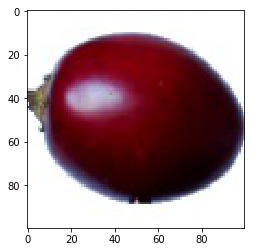

In [0]:
img = next(iter(train_loader))[0][0]
img = img.permute(1, 2, 0)
img = img.view(img.shape[0], img.shape[1], nb_channels)
plot_img(img)

## Models

In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(x_dim*y_dim*nb_channels, embedding_dim)
        self.fc21 = nn.Linear(embedding_dim, embedding_dim)
        self.fc22 = nn.Linear(embedding_dim, embedding_dim)
        self.fc3 = nn.Linear(embedding_dim, embedding_dim)
        self.fc4 = nn.Linear(embedding_dim, x_dim*y_dim*nb_channels)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, x_dim*y_dim*nb_channels))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [0]:

class VAE_CNN(nn.Module):
    def __init__(self):
        super(VAE_CNN, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv31 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn31 = nn.BatchNorm2d(128)
        self.conv32 = nn.Conv2d(128, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn32 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(16)

        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(25 * 25 * 16, embedding_dim)
        self.fc_bn1 = nn.BatchNorm1d(embedding_dim)
        self.fc21 = nn.Linear(embedding_dim, embedding_dim)
        self.fc22 = nn.Linear(embedding_dim, embedding_dim)

        # Sampling vector
        self.fc3 = nn.Linear(embedding_dim, embedding_dim)
        self.fc_bn3 = nn.BatchNorm1d(embedding_dim)
        self.fc4 = nn.Linear(embedding_dim, 25 * 25 * 16)
        self.fc_bn4 = nn.BatchNorm1d(25 * 25 * 16)

        # Decoder
        self.conv5 = nn.ConvTranspose2d(16, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1, bias=False)

        self.relu = nn.ReLU()

    def encode(self, x):
        conv1 = self.relu(self.bn1(self.conv1(x)))
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        conv31 = self.relu(self.bn31(self.conv31(conv3)))
        conv32 = self.relu(self.bn32(self.conv32(conv31)))
        conv4 = self.relu(self.bn4(self.conv4(conv32))).view(-1, 25 * 25 * 16)

        fc1 = self.relu(self.fc_bn1(self.fc1(conv4)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3))).view(-1, 16, 25, 25)

        conv5 = self.relu(self.bn5(self.conv5(fc4)))
        conv6 = self.relu(self.bn6(self.conv6(conv5)))
        conv7 = self.relu(self.bn7(self.conv7(conv6)))
        return self.conv8(conv7).view(-1, 3, 100, 100)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [0]:
model = VAE_CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Loss

In [0]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, x_dim*y_dim*nb_channels), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [0]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
        self.bce_loss = nn.BCELoss(reduction="sum")

    def forward(self, x_recon, x, mu, logvar):
        loss_rec = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_rec + loss_KLD

In [0]:
# Set loss function used by train and test here
loss_func = CustomLoss()

In [0]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_func(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [0]:
import os
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_func(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, nb_channels, x_dim, y_dim)[:n]])
                os.makedirs('results', exist_ok=True)
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [0]:
if __name__ == "__main__":
    for epoch in range(1, epochs + 1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(batch_size, embedding_dim).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(batch_size, nb_channels, x_dim, y_dim),
                       'results/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/56781 (0%)]	Loss: 23256.060547
Train Epoch: 1 [1280/56781 (2%)]	Loss: 8375.500977
Train Epoch: 1 [2560/56781 (5%)]	Loss: 3529.878174
Train Epoch: 1 [3840/56781 (7%)]	Loss: 1875.729736
Train Epoch: 1 [5120/56781 (9%)]	Loss: 1367.689941
Train Epoch: 1 [6400/56781 (11%)]	Loss: 1127.423706
Train Epoch: 1 [7680/56781 (14%)]	Loss: 991.961304
Train Epoch: 1 [8960/56781 (16%)]	Loss: 978.392883
Train Epoch: 1 [10240/56781 (18%)]	Loss: 821.072937
Train Epoch: 1 [11520/56781 (20%)]	Loss: 800.903687
Train Epoch: 1 [12800/56781 (23%)]	Loss: 798.959290
Train Epoch: 1 [14080/56781 (25%)]	Loss: 760.304932
Train Epoch: 1 [15360/56781 (27%)]	Loss: 681.244629
Train Epoch: 1 [16640/56781 (29%)]	Loss: 696.982056
Train Epoch: 1 [17920/56781 (32%)]	Loss: 650.655029
Train Epoch: 1 [19200/56781 (34%)]	Loss: 681.263306
Train Epoch: 1 [20480/56781 (36%)]	Loss: 651.933411
Train Epoch: 1 [21760/56781 (38%)]	Loss: 610.091553
Train Epoch: 1 [23040/56781 (41%)]	Loss: 591.742310
Train Epoch: 1 [24320

In [0]:
!ls results/

ls: cannot access 'results/': No such file or directory


In [0]:
from IPython.display import Image
Image("results/sample_19.png")